In [1]:
import numpy as np
import tensorflow as tf
from enum import Enum
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import Model, callbacks
from tensorflow.keras.regularizers import l1_l2
import pandas as pd
from sklearn.metrics import confusion_matrix
from scipy.interpolate import interp1d
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%matplotlib inline
sns.set(palette='Set2')
seed = 13
np.random.seed(seed)
tf.random.set_seed(seed)

plt.rc('figure', titlesize=26)
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=16)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('legend', fontsize=16)
plt.rc('figure', figsize=(12,8))

In [3]:
with open('data/batch1.pkl', 'rb') as f:
    batch1 = np.load(f)
#remove batteries that do not reach 80% capacity
del batch1['b1c8']
del batch1['b1c10']
del batch1['b1c12']
del batch1['b1c13']
del batch1['b1c22']

with open('data/batch2.pkl', 'rb') as f:
    batch2 = np.load(f)
batch2_keys = ['b2c7', 'b2c8', 'b2c9', 'b2c15', 'b2c16']
batch1_keys = ['b1c0', 'b1c1', 'b1c2', 'b1c3', 'b1c4']
add_len = [662, 981, 1060, 208, 482];

# There are four cells from batch1 that carried into batch2, we'll remove the data from batch2
# and put it with the correct cell from batch1
for i, bk in enumerate(batch1_keys):
    batch1[bk]['cycle_life'] = batch1[bk]['cycle_life'] + add_len[i]
    for j in batch1[bk]['summary'].keys():
        if j == 'cycle':
            batch1[bk]['summary'][j] = np.hstack((batch1[bk]['summary'][j], batch2[batch2_keys[i]]['summary'][j] + len(batch1[bk]['summary'][j])))
        else:
            batch1[bk]['summary'][j] = np.hstack((batch1[bk]['summary'][j], batch2[batch2_keys[i]]['summary'][j]))
    last_cycle = len(batch1[bk]['cycles'].keys())
    for j, jk in enumerate(batch2[batch2_keys[i]]['cycles'].keys()):
        batch1[bk]['cycles'][str(last_cycle + j)] = batch2[batch2_keys[i]]['cycles'][jk]
        
del batch2['b2c7']
del batch2['b2c8']
del batch2['b2c9']
del batch2['b2c15']
del batch2['b2c16']

with open('data/batch3.pkl', 'rb') as f:
    batch3 = np.load(f)
    
# remove noisy channels from batch3
del batch3['b3c37']
del batch3['b3c2']
del batch3['b3c23']
del batch3['b3c32']
del batch3['b3c38']
del batch3['b3c39']

batch1_size = len(batch1.keys())
batch2_size = len(batch2.keys())
batch3_size = len(batch3.keys())

batch_size = batch1_size + batch2_size + batch3_size

batches = {**batch1, **batch2, **batch3}

del batch1
del batch2
del batch3

# Paper & dataset

* Stanford/MIT/Berkeley/Toyota
* Published in Nature
* 4.9% test error for classification into two groups
* 9.1% test error predicting cycle life
* 124 commercial lithium-iron phosphate/graphite (LFP) cells cycled under fast-charging conditions
* Cycle lives ranging from 150 to 2300 cycles

In [4]:
test_ind = np.hstack((np.arange(0,(batch1_size+batch2_size),2),83))
train_ind = np.arange(1,(batch1_size+batch2_size-1),2)
secondary_test_ind = np.arange(batch_size-batch3_size,batch_size)

# What is a "bad" battery?
In this paper, defined as 80% state-of-health, or 80% of nominal capacity. In this case: 1.1*0.8 Ah

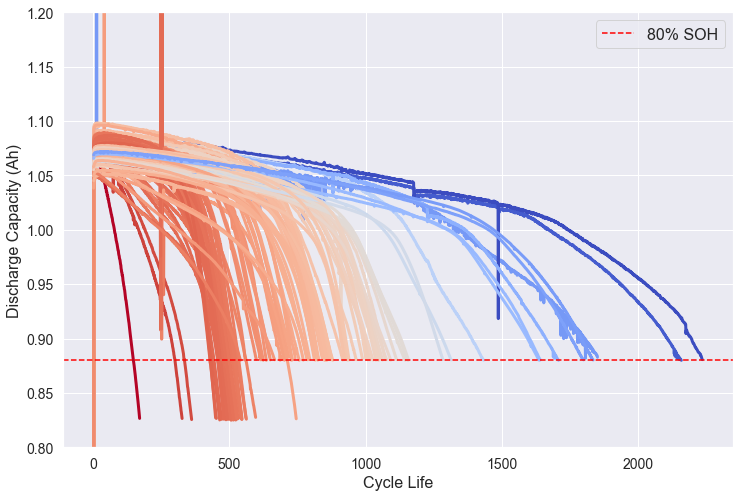

In [5]:
cycle_lives = np.array([cell['cycle_life'] for cell in batches.values()]).ravel()

cmap = plt.get_cmap('coolwarm_r')
norm = matplotlib.colors.Normalize(vmin=np.min(cycle_lives), vmax=np.max(cycle_lives))
mapper = plt.cm.ScalarMappable(norm=norm, cmap=cmap)

for idx, i in enumerate(batches.keys()):
    cell = batches[i]
    plt.plot(cell['summary']['cycle'], cell['summary']['QD'],
             c=mapper.to_rgba(float(cell['cycle_life'])), linewidth=3)
plt.xlabel('Cycle Life')
plt.axhline(1.1*0.8, linestyle='--', color='r', label='80% SOH')
plt.ylim(0.8, 1.2)
plt.ylabel('Discharge Capacity (Ah)')
plt.legend()
plt.show()

Text(0.5, 0, 'Count')

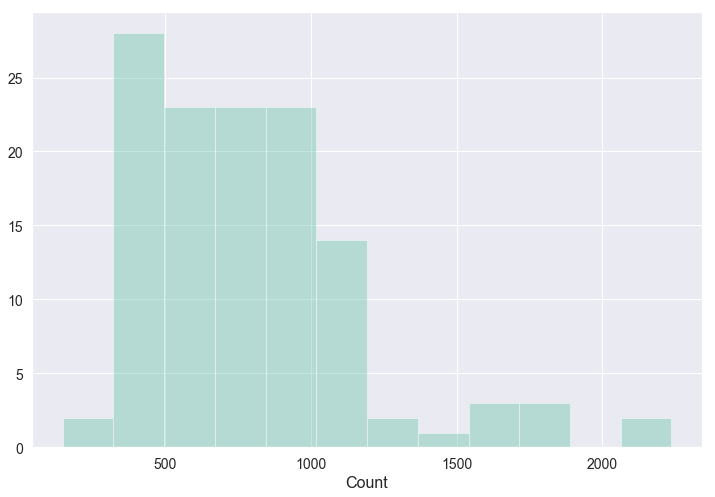

In [6]:
cycle_lives = np.array([cell['cycle_life'] for cell in batches.values()]).flatten()

sns.distplot(cycle_lives, kde=False)
plt.xlabel('Cycle Life')
plt.xlabel('Count')

In [7]:
print('Cell count: ', len(batches))
print('Cell names: ', batches.keys())

cell = batches['b2c31']

Cell count:  124
Cell names:  dict_keys(['b1c0', 'b1c1', 'b1c2', 'b1c3', 'b1c4', 'b1c5', 'b1c6', 'b1c7', 'b1c9', 'b1c11', 'b1c14', 'b1c15', 'b1c16', 'b1c17', 'b1c18', 'b1c19', 'b1c20', 'b1c21', 'b1c23', 'b1c24', 'b1c25', 'b1c26', 'b1c27', 'b1c28', 'b1c29', 'b1c30', 'b1c31', 'b1c32', 'b1c33', 'b1c34', 'b1c35', 'b1c36', 'b1c37', 'b1c38', 'b1c39', 'b1c40', 'b1c41', 'b1c42', 'b1c43', 'b1c44', 'b1c45', 'b2c0', 'b2c1', 'b2c2', 'b2c3', 'b2c4', 'b2c5', 'b2c6', 'b2c10', 'b2c11', 'b2c12', 'b2c13', 'b2c14', 'b2c17', 'b2c18', 'b2c19', 'b2c20', 'b2c21', 'b2c22', 'b2c23', 'b2c24', 'b2c25', 'b2c26', 'b2c27', 'b2c28', 'b2c29', 'b2c30', 'b2c31', 'b2c32', 'b2c33', 'b2c34', 'b2c35', 'b2c36', 'b2c37', 'b2c38', 'b2c39', 'b2c40', 'b2c41', 'b2c42', 'b2c43', 'b2c44', 'b2c45', 'b2c46', 'b2c47', 'b3c0', 'b3c1', 'b3c3', 'b3c4', 'b3c5', 'b3c6', 'b3c7', 'b3c8', 'b3c9', 'b3c10', 'b3c11', 'b3c12', 'b3c13', 'b3c14', 'b3c15', 'b3c16', 'b3c17', 'b3c18', 'b3c19', 'b3c20', 'b3c21', 'b3c22', 'b3c24', 'b3c25', 'b3c26', 'b3

In [8]:
summary = batches['b1c41']['summary']
summary_keys = summary.keys()
print('summary keys:', summary_keys)
print('cycle keys:', cell['cycles']['1'].keys())

summary keys: dict_keys(['IR', 'QC', 'QD', 'Tavg', 'Tmin', 'Tmax', 'chargetime', 'cycle'])
cycle keys: dict_keys(['I', 'Qc', 'Qd', 'Qdlin', 'T', 'Tdlin', 'V', 'dQdV', 't'])


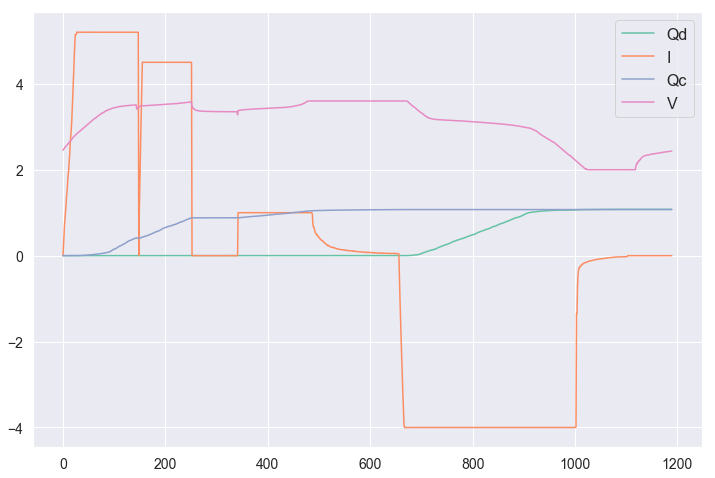

In [9]:
cycle = cell['cycles']['10']
Qd = cycle['Qd']
I = cycle['I']
s = slice(len(Qd))

V = cycle['V']

plt.plot(Qd[s], label='Qd')
plt.plot(I[s], label='I')
plt.plot(cell['cycles']['1']['Qc'][s], label='Qc')
plt.plot(cell['cycles']['1']['V'][s], label='V')
# plt.plot(cell['cycles']['1']['Qdlin'][s], label='Qdlin')
# plt.plot(summary['IR'], label='IR')
plt.legend()

In [10]:
def get_QV(cycle, num=1000):
    V = cycle['V']
    Qd = cycle['Qdlin']
    v = np.linspace(np.max(V), np.min(V), num=len(Qd), endpoint=True)
    return Qd, v

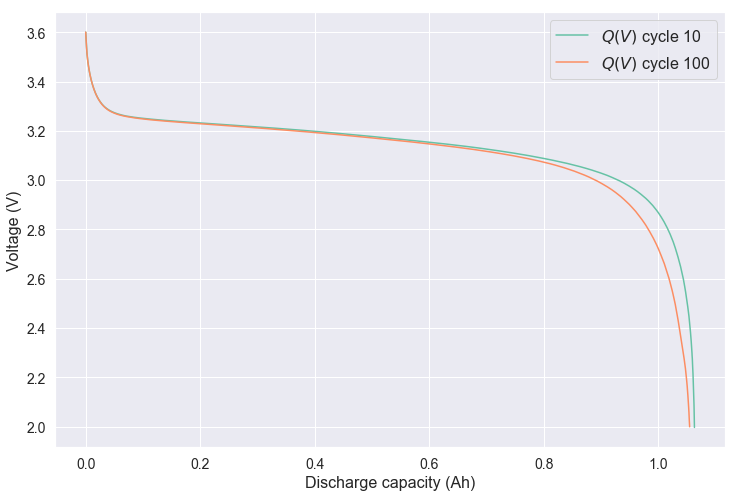

In [11]:
for cycle in [10, 100]:
    qd, v = get_QV(cell['cycles'][str(cycle)])
    plt.plot(qd, v, label='$Q(V)$ cycle {}'.format(cycle))
    plt.xlabel('Discharge capacity (Ah)')
    plt.ylabel('Voltage (V)')
plt.legend()
plt.show()

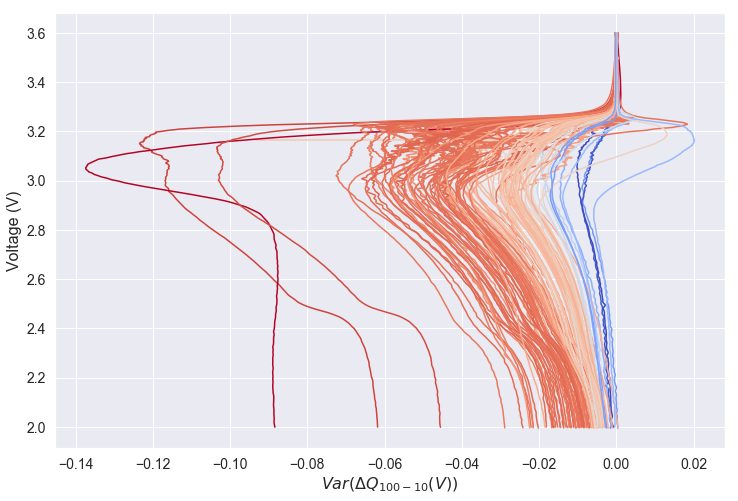

In [12]:
cycle_lives = np.array([cell['cycle_life'] for cell in batches.values()]).ravel()

cmap = plt.get_cmap('coolwarm_r')
norm = matplotlib.colors.Normalize(vmin=np.min(cycle_lives), vmax=np.max(cycle_lives))
mapper = plt.cm.ScalarMappable(norm=norm, cmap=cmap)

for cell in batches.values():
    qd100, v = get_QV(cell['cycles'][str(100)])
    qd10, v = get_QV(cell['cycles'][str(10)])

    diff = qd100-qd10

    cl = float(cell['cycle_life'])
    plt.plot(diff, v, c=mapper.to_rgba(cl))
    
plt.xlabel('$Var(\Delta Q_{100-10}(V))$')
plt.ylabel('Voltage (V)')
plt.show()

In [13]:
def interpolateQV(cycle, num=1000, value=None):
    V = cycle['V']
    Qd = cycle['Qd']

    diff = cycle['Qc'] - Qd
    I = cycle['I']
    from_idx = np.where(I < 0)[0][0]-1
    I = I[from_idx:]
    to_idx = np.where(I >= 0)[0][0]-1
    V = V[from_idx:to_idx]
    Qd = Qd[from_idx:to_idx]
    v = np.linspace(V[0], V[-1], num=num, endpoint=True)
    f = interp1d(V, Qd)
    if value is None:
        return f(v), v
    else:
        return f(value), value

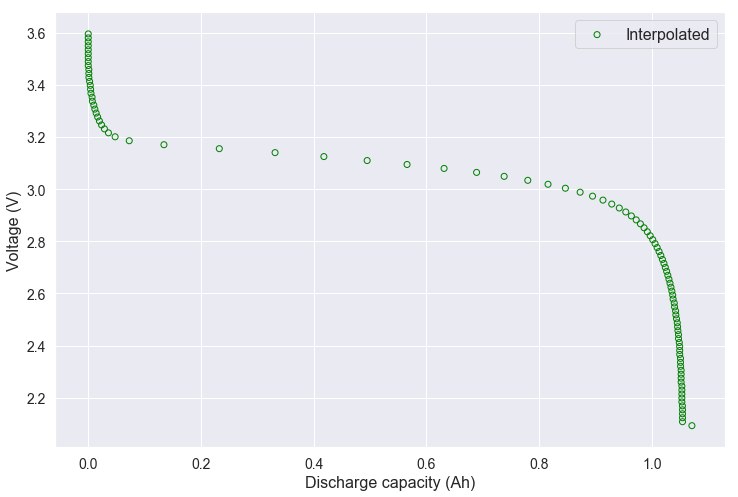

In [14]:
cycle = 10
qd, v = interpolateQV(cell['cycles'][str(cycle)], num=100)
plt.scatter(qd, v, label='Interpolated', edgecolors='g', facecolors='none')
plt.xlabel('Discharge capacity (Ah)')
plt.ylabel('Voltage (V)')
plt.legend()
plt.show()

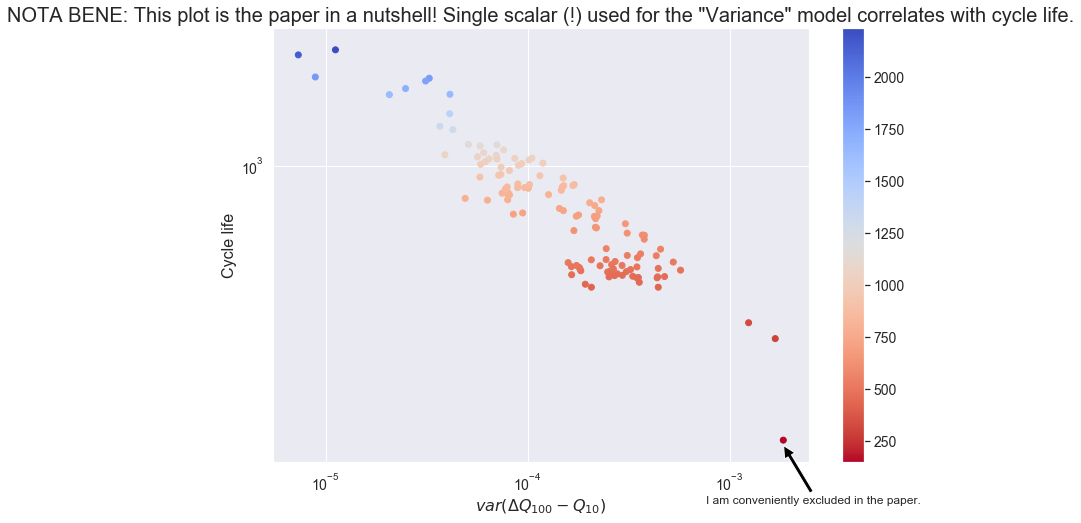

p corr:  -0.9124174890598451


In [15]:
xs, ys = [], []

for cell in batches.values():
    qv10, v = get_QV(cell['cycles'][str(10)])
    qv100, v = get_QV(cell['cycles'][str(100)])
    var = np.var(qv100 - qv10)

    xs.append(var)
    ys.append(cell['cycle_life'][:])

    
worst_battery = np.argmax(xs)

plt.annotate('I am conveniently excluded in the paper.',
            xy=(xs[worst_battery], ys[worst_battery]-5),
            xytext=(30, -50.0),    # fraction, fraction
            textcoords='offset points',
            arrowprops=dict(facecolor='black', alpha=1, shrink=0.01),
            horizontalalignment='center',
            verticalalignment='top',
            )

# del xs[worst_battery]
# del ys[worst_battery]

xs = np.array(xs).reshape(-1, 1)
ys = np.array(ys).reshape(-1, 1)

ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')

cm = plt.cm.get_cmap('coolwarm_r')

sc = plt.scatter(xs, ys, c=ys, cmap=cm)
    
plt.colorbar(sc)
plt.ylabel('Cycle life')
plt.xlabel(r'$var(\Delta Q_{100} - Q_{10})$')
plt.title('NOTA BENE: This plot is the paper in a nutshell! Single scalar (!) used for the "Variance" model correlates with cycle life.')

plt.show()

xs = np.array(xs).reshape(-1)
ys = np.array(ys).reshape(-1)
print('p corr: ', np.corrcoef(np.log(xs), np.log(ys))[0,1])



# From paper:

![paper_qvar](img/paper_qvar.png)

In [16]:
# How many cycles to look at?
n_cycles = 100
n_inputs = 1000

N_EPOCHS = 1000

In [17]:
class ModelType(Enum):
    VARIANCE = 0
    DISCHARGE = 1
    FULL = 2
        
class ModelSpec(object):

    def __init__(self, model_type=ModelType.VARIANCE, cycles=[(100, 10)]):
        self.model_type = model_type
        self.cycles = cycles
        self.cycle_life_boundary = 550

# Classification

In [18]:
from sklearn.preprocessing import MinMaxScaler

def get_classifier_dataset(d, spec, n_cycles, n_inputs):
    
    assert spec
    
    if spec.model_type == ModelType.DISCHARGE:
        keys = ['Qd']
        n_features = len(keys)
    elif spec.model_type == ModelType.FULL:
        keys = next(iter(d.values()))['cycles']['1'].keys()
        n_features = len(keys)
    else:
        n_features = 1

    cycle_lives = np.array([cell['cycle_life'].flatten() for cell in d.values()])
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler.fit(cycle_lives)
    data = None
    variances = np.empty(shape=(len(d), 1))
    
    X = None
    Y = None
    cycle_lives = None
    
    for idx, (name, cell) in enumerate(d.items()):
        
        q_vars = []
        q_diffs = []
        for c2, c1 in spec.cycles:
            qd2, v = get_QV(cell['cycles'][str(c2)])
            qd1, v = get_QV(cell['cycles'][str(c1)])
            q_diff = qd2 - qd1
            q_diffs.append(q_diff)
            q_var = np.var(q_diff)
            q_var = np.log(q_var)
            q_vars.append(q_var)
        
        if spec.model_type == ModelType.VARIANCE:
            features = np.array(q_vars)
        elif spec.model_type == ModelType.DISCHARGE:
            q_min = np.log(np.abs(np.min(q_diffs, axis=1)))
            q_mean = np.log(np.abs(np.mean(q_diffs, axis=1)))
            
            q_at_2vs = []
            for c2, c1 in spec.cycles:
                qv2, _ = interpolateQV(cell['cycles'][str(c2)], value=2)
                qv1, _ = interpolateQV(cell['cycles'][str(c1)], value=2)
                qv2diff = np.log(np.abs(qv2-qv1))
                q_at_2vs.append(qv2diff)
                
            #min_temp = np.min(cell['summary']['Tmin'][:100])
            #max_temp = np.max(cell['summary']['Tmax'][:100])
            features = np.hstack([q_vars, q_min, q_mean, q_at_2vs]).flatten()
        else:
            features = np.zeros(shape=(n_cycles, n_features, n_inputs))
            for i in range(n_cycles):
                cycle = cell['cycles'][str(i+1)]
                for j, key in enumerate(keys):
                    
                    q, v = get_QV(cycle, n_inputs)
                    features[i,j,:] = q
                    
        x = features.flatten()
        cycle_life = cell['cycle_life']
        if type(spec.cycle_life_boundary) == int:
            y = 0.0 if cycle_life < spec.cycle_life_boundary else 1.0
        else:
            for c, boundary in enumerate(spec.cycle_life_boundary):
                if cycle_life < boundary:
                    break
            y = np.eye(len(spec.cycle_life_boundary)+1)[c]
        y = np.array([y])
        xy = (x, y, cycle_life)
        if X is None:
            X = x
            Y = y
            cycle_lives = cycle_life
        else:
            X = np.vstack([X, x])
            Y = np.vstack([Y, y])
            cycle_lives = np.vstack([cycle_lives, cycle_life])
    return X, Y, cycle_lives

In [19]:
def get_data(spec):
    X, Y, cycle_lives = get_classifier_dataset(batches, spec, n_cycles, n_inputs)

    return np.array([(X[ind], Y[ind], cycle_lives[ind]) for ind in [train_ind, test_ind, secondary_test_ind]]).flatten()

In [20]:
def train(x_train, y_train, x_val, y_val):
    tf.keras.backend.clear_session()
    
    def regularizer(alpha=0.6, lambda_=0.01):
        l1 = alpha
        l2 = (1-l1)/2
        return l1_l2(l1=lambda_*l1, l2=lambda_*l2)
        
    input_shape = x_train.shape[-1]
    inputs = tf.keras.Input(shape=(input_shape,))
    x = Dense(32, activation='elu', kernel_regularizer=regularizer())(inputs)
    outputs = Dense(y_train.shape[-1], activation='sigmoid')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    lr = 0.1
    optimizer = tf.keras.optimizers.Adam(lr=lr)
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['binary_accuracy', 
                            tf.keras.metrics.TruePositives(), 
                            tf.keras.metrics.FalsePositives(),
                            tf.keras.metrics.TrueNegatives(),
                            tf.keras.metrics.FalseNegatives(),
                 tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

    early_stopping = callbacks.EarlyStopping(monitor='val_loss', min_delta=0, 
                                                      patience=10, verbose=0, mode='auto', 
                                                      baseline=None, restore_best_weights=True)

    reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                  patience=10, min_lr=1e-6)

    model.fit(x_train, y_train, batch_size=len(x_train), epochs=N_EPOCHS,
              validation_data=(x_val, y_val), verbose=0,
             callbacks=[reduce_lr, early_stopping])
    
    return model

In [21]:
def evaluate(model, spec, x_test, y_test):
    ev = model.evaluate(x_test, y_test, verbose=1)

    accuracy = ev[1]
    tp = ev[2]
    fp = ev[3]
    tn = ev[4]
    fn = ev[5]
    precision = ev[-2]
    recall = ev[-1]
    
    sensitivity = tp / (tp+fn)
    specificity = tn / (tn+fp)
    
    f1_score = 2*(precision*recall)/(precision+recall+1e-9)
    balanced_acc = (sensitivity+specificity)/2

    pred = model.predict(x_test)
    cycle_lives = cycle_life_test
    sc = plt.scatter(cycle_lives, pred, s=100, c=-pred, cmap='coolwarm')
    ax = plt.gca()
    plt.axvline(spec.cycle_life_boundary, c='r')
    plt.axhline(0.5, linestyle='--')
    plt.ylabel('Probability cycle life > {}'.format(spec.cycle_life_boundary))
    plt.xlabel('Cycle life')
    plt.ylim(0, 1)

    plt.title('Test accuracy: {:.2f}, F1 score: {:.2f}, Balanced acc: {:.2f}'.format(accuracy, f1_score, balanced_acc))

    maxx = plt.axis()[1] + 50
    miny = plt.axis()[-2]
    maxy = plt.axis()[-1]

    plt.annotate(
        '', xy=(maxx, 0.5),
        xytext=(maxx, maxy),
        arrowprops={'arrowstyle': '<->'}, annotation_clip=False)

    plt.annotate(
        'predicted >550', xy=(maxx, 0.75), xycoords='data',
        xytext=(5, 0), textcoords='offset points',
        annotation_clip=False)

    plt.annotate(
        '', xy=(maxx, miny),
        xytext=(maxx, 0.5),
        arrowprops={'arrowstyle': '<->'},
        annotation_clip=False)

    plt.annotate(
        'predicted <550', xy=(maxx, 0.25), xycoords='data',
        xytext=(5, 0), textcoords='offset points',
        annotation_clip=False)

    plt.show()

# Paper reports great results using only first 5 cycles for classification

In [22]:
cycles = [(5,4)]
spec = ModelSpec(cycles=cycles)
x_train, y_train, cycle_life_train, x_val, y_val, cycle_life_val, x_test, y_test, cycle_life_test = get_data(spec)
model = train(x_train, y_train, x_val, y_val)

In [23]:
results = model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy: {:.2f}'.format(results[1]))

Test accuracy: 0.93


# Fantastic results... or?

# From paper:
![classification](img/paper_classification.png)

### With accuracy as a measure, just classifying ALL batteries would yield 39/40=0.975 accuracy. Which is exactly what the paper reports...

Better to use F-score or balanced accuracy to compensate for the skewed dataset. Also, where does this magical 550 boundary come from? The spec for the battery expects 1000 cycles: https://www.batteryspace.com/prod-specs/6612.pdf

# Metrics

* Accuracy = correct / (correct + incorrect)
* Precision = true positive / (true positive + false positive), eg: rate of correct positives
* Recall/Sensitivity = true positives / (true positives + false negatives), eg: correctly detect ill (a negative result with high sensitivity is meaningful). 
> If sensitivity is high, a negative result means good state of health

* Specificity = true negative / (true negative + false positive), eg: corectly reject healthy (a positive result with high specificity is meaningful).
> If specificity is high, a positive result means bad state of health



## F1 score
F1 score: $2 * \frac{precision*recall}{precision+recall}$

Good when you have many negative examples

## Balanced accuracy

Balanced accuracy: $0.5*(sensitivity+specificity)$

Good when you have many positive examples.

# Looking at the data is helpful

40/40 [==============================] - 0s 211us/sample - loss: 0.3375 - binary_accuracy: 0.9250 - true_positives: 37.0000 - false_positives: 1.0000 - true_negatives: 0.0000e+00 - false_negatives: 2.0000 - precision: 0.9737 - recall: 0.9487


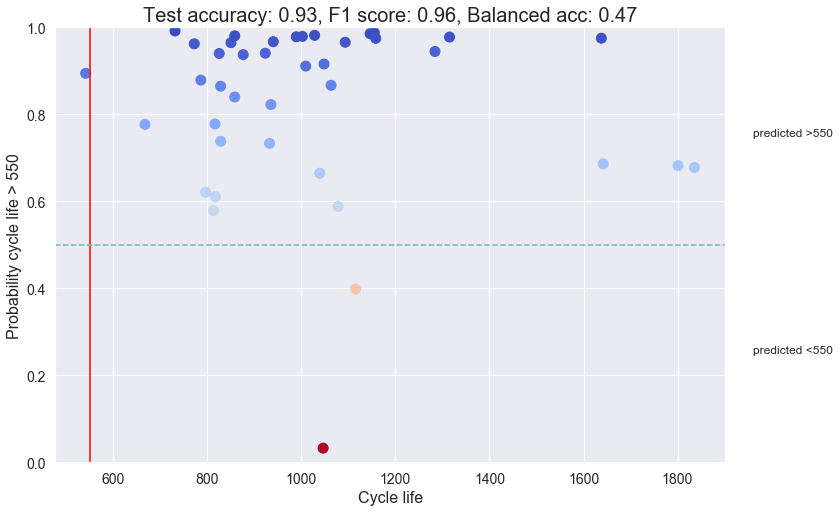

In [24]:
evaluate(model, spec, x_test, y_test)

# So results look terrible despite accuracy of 93%. But what happens if we increase number of cycles seen to 100?

In [25]:
cycles = [(100,10)]
spec = ModelSpec(cycles=cycles)
x_train, y_train, cl_train, x_val, y_val, cl_val, x_test, y_test, cl_test = get_data(spec)
model = train(x_train, y_train, x_val, y_val)

40/40 [==============================] - 0s 93us/sample - loss: 0.1437 - binary_accuracy: 0.9750 - true_positives: 38.0000 - false_positives: 0.0000e+00 - true_negatives: 1.0000 - false_negatives: 1.0000 - precision: 1.0000 - recall: 0.9744


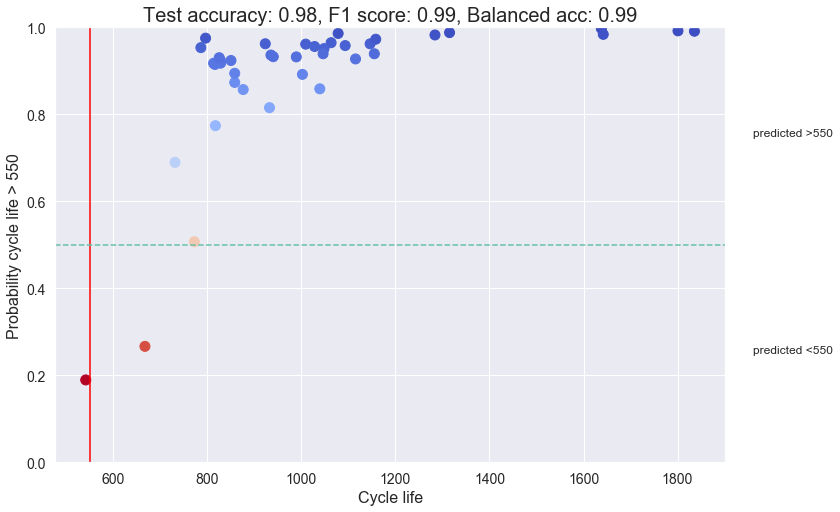

In [26]:
evaluate(model, spec, x_test, y_test)

# How low can we go? 50 cycles?

In [27]:
cycles = [(50,10)]
spec = ModelSpec(cycles=cycles)
x_train, y_train, cycle_life_train, x_val, y_val, cycle_life_val, x_test, y_test, cycle_life_test = get_data(spec)
model = train(x_train, y_train, x_val, y_val)

40/40 [==============================] - 0s 87us/sample - loss: 0.1297 - binary_accuracy: 0.9750 - true_positives: 38.0000 - false_positives: 0.0000e+00 - true_negatives: 1.0000 - false_negatives: 1.0000 - precision: 1.0000 - recall: 0.9744


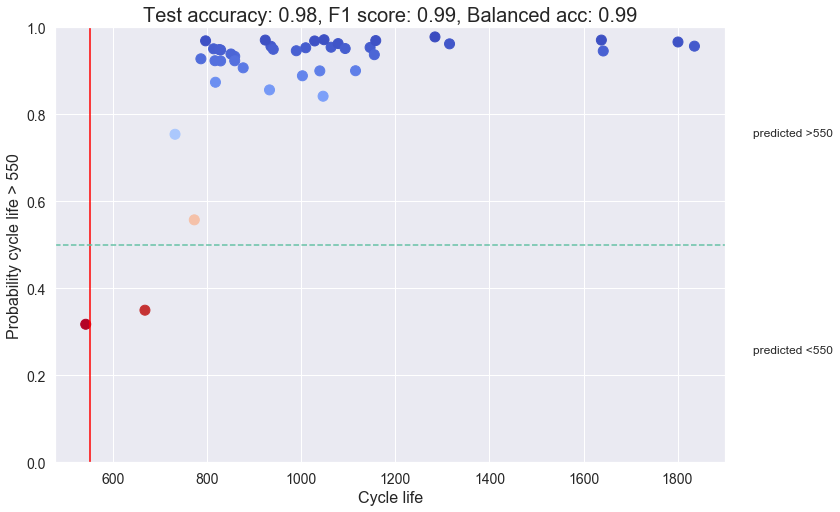

In [28]:
evaluate(model, spec, x_test, y_test)

# What about 30 cycles?

In [29]:
cycles = [(30,10)]
spec = ModelSpec(cycles=cycles)
x_train, y_train, cycle_life_train, x_val, y_val, cycle_life_val, x_test, y_test, cycle_life_test = get_data(spec)
model = train(x_train, y_train, x_val, y_val)

40/40 [==============================] - 0s 79us/sample - loss: 0.3324 - binary_accuracy: 0.9250 - true_positives: 36.0000 - false_positives: 0.0000e+00 - true_negatives: 1.0000 - false_negatives: 3.0000 - precision: 1.0000 - recall: 0.9231


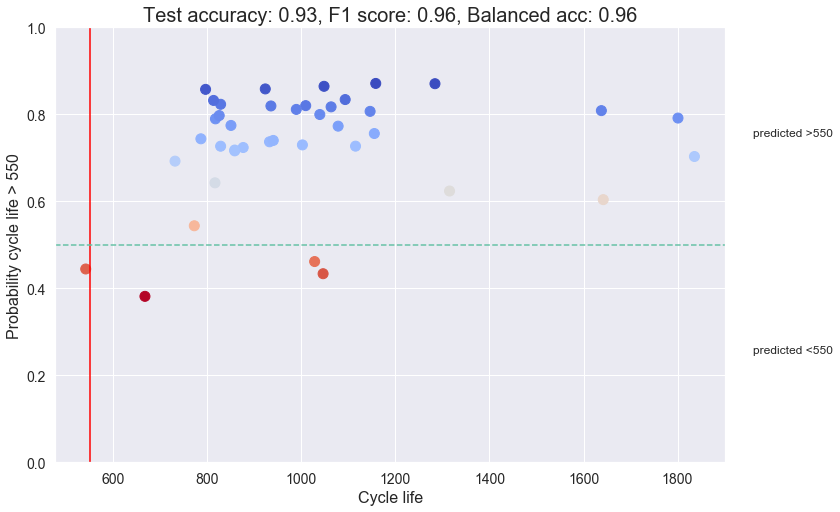

In [30]:
evaluate(model, spec, x_test, y_test)

# Multiclass classification

In [31]:
def train_categorical(x_train, y_train, x_val, y_val):
    tf.keras.backend.clear_session()
    
    def regularizer(alpha=0.6, lambda_=1e-2):
        l1 = alpha
        l2 = (1-l1)/2
        return l1_l2(l1=lambda_*l1, l2=lambda_*l2)
        
    input_shape = x_train.shape[-1]
    inputs = tf.keras.Input(shape=(input_shape,))
    x = Dense(32, activation='relu', kernel_regularizer=regularizer())(inputs)
    x = Dense(32, activation='relu', kernel_regularizer=regularizer())(x)
    x = Dense(32, activation='relu', kernel_regularizer=regularizer())(x)
    outputs = Dense(y_train.shape[-1], activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    lr = 0.01
    optimizer = tf.keras.optimizers.Adam(lr=lr)
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['categorical_accuracy'])

    early_stopping = callbacks.EarlyStopping(monitor='val_loss', min_delta=0, 
                                                      patience=100, verbose=0, mode='auto', 
                                                      baseline=None, restore_best_weights=True)

    reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                  patience=10, min_lr=1e-6)

    model.fit(x_train, y_train, batch_size=len(x_train), epochs=N_EPOCHS,
              validation_data=(x_val, y_val), verbose=0,
             callbacks=[reduce_lr, early_stopping])
    
    return model

In [32]:
def evaluate_categorical(model, spec, x_test, y_test):
    ev = model.evaluate(x_test, y_test, verbose=1)
    y_pred = model.predict(x_test)
    
    accuracy = ev[1]

    n_classes = y_train.shape[-1]
    
    classnames = ['life <{}'.format(cl) for cl in spec.cycle_life_boundary]
    confusion = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
    df_cm = pd.DataFrame(confusion, index=[name for name in classnames],
                  columns=[name for name in classnames])
    plt.figure(figsize = (10,10))
    sns.set_palette('viridis')
    sns.heatmap(df_cm, annot=True, cbar=False, cmap='gray')
    plt.ylabel('True class')
    plt.xlabel('Predicted class')

    plt.title('Test accuracy: {:.2f}'.format(accuracy))

# Confusion matrix (want a strong diagonal)

40/40 [==============================] - 0s 61us/sample - loss: 0.6237 - categorical_accuracy: 0.7750


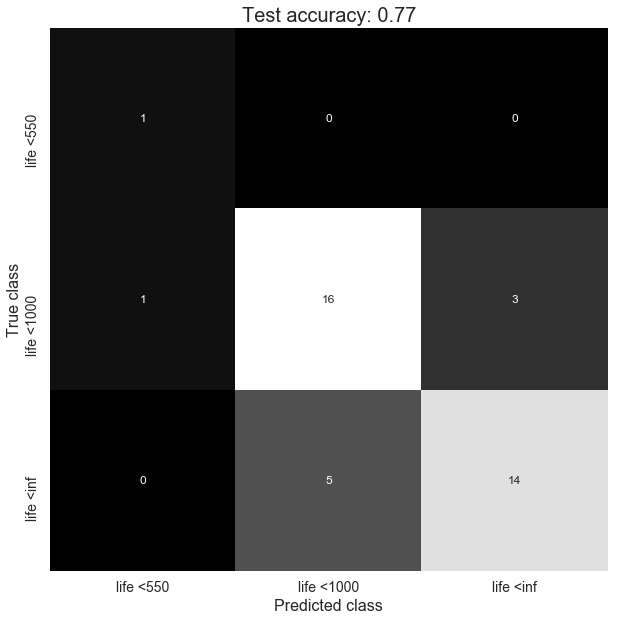

In [33]:
cycles = [(100, 10)]
spec = ModelSpec(cycles=cycles, model_type=ModelType.VARIANCE)
spec.cycle_life_boundary = [550, 1000, np.inf]
x_train, y_train, cl_train, x_val, y_val, cl_val, x_test, y_test, cl_test = get_data(spec)
model = train_categorical(x_train, y_train, x_val, y_val)
evaluate_categorical(model, spec, x_test, y_test)


In [34]:
cycles = [(100, 10)]
spec = ModelSpec(cycles=cycles, model_type=ModelType.VARIANCE)
spec.cycle_life_boundary = [550, 800, 1000, 1200, 1500, np.inf]
x_train, y_train, cl_train, x_val, y_val, cl_val, x_test, y_test, cl_test = get_data(spec)
model = train_categorical(x_train, y_train, x_val, y_val)

40/40 [==============================] - 0s 135us/sample - loss: 1.2054 - categorical_accuracy: 0.5000


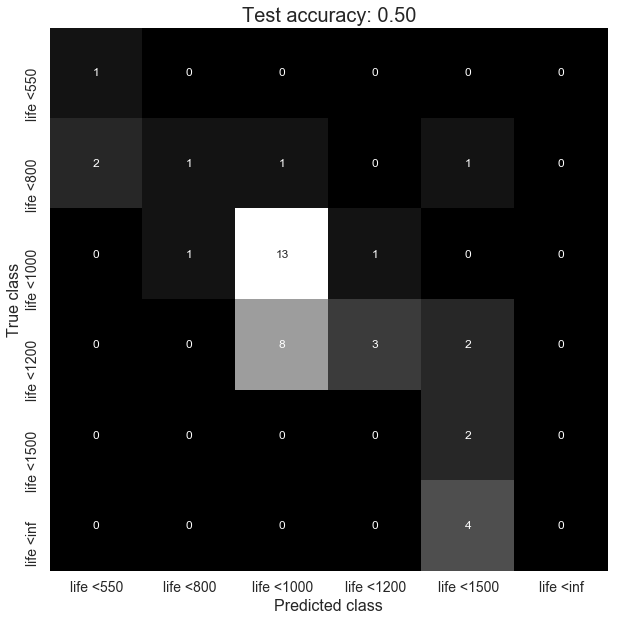

In [35]:
evaluate_categorical(model, spec, x_test, y_test)

## Accuracy means very little. 

It's more important to look at what kind of errors we want to avoid. If we want to be conservative, eg avoid Type 1 errors (false positives / bad batteries classified as good), then we want a strong lower diagonal. If we want to avoid Type 2 errors (false negatives / good batteries classified as bad), we want a strong upper diagonal.